# Project: Chicago Traffic Crash Time-Series Analysis & Forecasting

**Objective:** To perform a time-series analysis of Chicago traffic crashes reported in Chicago in the time period 2018 to 2020 and to map the locations of fatal vehicle crashes.

**Tools Used:** Python, Pandas, Matplotlib, Seaborn, Folium, Prophet

**Skills Demonstrated:** Data Cleaning, Exploratory Data Analysis, Time-Series Analysis and Forecasting, Data Visualization, Coordinate Mapping

**Data Source:** https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3, https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

import folium
from folium import plugins
from folium.plugins import HeatMapWithTime

import fbprophet

## Exploratory Data Analysis & Time-Series Analysis

### 1. Import Data

In [2]:
# Import the source data and merge.
df_crashes = pd.read_csv('crashes.csv', low_memory=False)
df_vehicles = pd.read_csv('crashes_vehicles.csv', low_memory=False).drop('CRASH_DATE', axis=1)
df = pd.merge(df_crashes, df_vehicles, on='CRASH_RECORD_ID').reset_index()

In [3]:
# Change the CRASH_DATE column to date data type.
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')
df_crashes['CRASH_DATE'] = pd.to_datetime(df_crashes['CRASH_DATE'], errors='coerce')

### 2. Overview of Data

In [4]:
# Display the number of crashes per year in the data set.
df.groupby(df['CRASH_DATE'].dt.year)['CRASH_RECORD_ID'].nunique().reset_index(name='COUNT OF CRASHES')

,CRASH_DATE,COUNT OF CRASHES
0,2013,1
1,2014,6
2,2015,9828
3,2016,44296
4,2017,83785
5,2018,118946
6,2019,117751
7,2020,92061
8,2021,7588


In [5]:
# Subset DataFrame to include only crashes from 2018, 2019 and 2020, because other years contain only partial data.
df = df[(df['CRASH_DATE'] >= '2018-01-01') & (df['CRASH_DATE'] <= '2020-12-31')]

# Make a copy of the DataFrame for later forecasting.
df_forecast = df.copy()

In [6]:
df.head(10)

,index,CRASH_RECORD_ID,RD_NO_x,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,JC343143,NaN,2019-07-10 17:56:00,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,JC343143,NaN,2019-07-10 17:56:00,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,2020-07-10 10:25:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,2020-07-10 10:25:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,2020-07-10 10:25:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,2020-07-11 01:00:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,2020-07-11 01:00:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,2020-07-08 14:00:00,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,10,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,2020-07-08 14:00:00,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,11,00e47f189660cd8ba1e85fc63061bf1d8465184393f134...,JC194776,NaN,2019-03-21 22:50:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.describe()

,index,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,...,UNIT_NO,NUM_PASSENGERS,VEHICLE_ID,VEHICLE_YEAR,OCCUPANT_CNT,CMV_ID,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT
count,672831.000000,672831.000000,187004.000000,672831.000000,672831.000000,672831.000000,671580.000000,671580.000000,671580.000000,671580.000000,...,672831.000000,103660.000000,655675.000000,548142.000000,655675.000000,8057.000000,1254.000000,29.000000,1509.000000,2241.000000
mean,487588.003881,28.474757,2.524866,3678.418881,1254.771943,2.143779,0.213304,0.001328,0.023519,0.121338,...,1.567932,1.479983,626054.524376,2012.744347,1.089694,6783.594886,48.080542,44.931034,53.410205,15.353860
std,277464.524200,6.035455,1.838988,2834.012719,703.847938,0.607554,0.611909,0.039669,0.182205,0.458925,...,0.645204,1.099614,196241.311938,121.192439,0.797858,2625.072544,15.586969,29.694794,36.887195,549.348189
min,0.000000,0.000000,0.000000,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,285043.000000,1900.000000,0.000000,2279.000000,1.000000,2.000000,1.000000,1.000000
25%,247635.500000,30.000000,2.000000,1260.000000,723.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,455961.500000,2006.000000,1.000000,4499.000000,43.000000,25.000000,35.000000,2.000000
50%,487266.000000,30.000000,2.000000,3200.000000,1214.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,626834.000000,2012.000000,1.000000,6794.000000,53.000000,45.000000,53.000000,3.000000
75%,727876.500000,30.000000,4.000000,5537.000000,1822.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,796322.500000,2016.000000,1.000000,9068.000000,53.000000,53.000000,65.000000,5.000000
max,967749.000000,70.000000,99.000000,13799.000000,6100.000000,18.000000,21.000000,3.000000,7.000000,21.000000,...,18.000000,59.000000,980868.000000,9999.000000,60.000000,11319.000000,125.000000,120.000000,999.000000,26009.000000


In [8]:
# Review columns with null values.
pd.options.display.max_rows = 150
df.isna().sum().sort_values(ascending=False)

HAZMAT_REPORT_NO                 672831
MCS_REPORT_NO                    672827
TRAILER2_LENGTH                  672802
HAZMAT_NAME                      672797
WIDE_LOAD_I                      672753
TRAILER2_WIDTH                   672663
HAZMAT_PLACARDS_I                672656
UN_NO                            672526
IDOT_PERMIT_NO                   672363
FIRE_I                           672271
HAZMAT_CLASS                     672260
ILCC_NO                          672096
WORKERS_PRESENT_I                671810
CCMC_NO                          671761
TRAILER1_LENGTH                  671577
EXCEED_SPEED_LIMIT_I             671471
TOTAL_VEHICLE_LENGTH             671322
TRAILER1_WIDTH                   671307
AXLE_CNT                         670590
DOORING_I                        670560
WORK_ZONE_TYPE                   669894
WORK_ZONE_I                      669129
GVWR                             668118
USDOT_NO                         668107
HAZMAT_OUT_OF_SERVICE_I          667279


### 3. Explore Number of Crashes Per Month, Day of Week and Time of Day

In [9]:
# Display the number of crashes represented in the dataset.
df['CRASH_RECORD_ID'].nunique()

328494

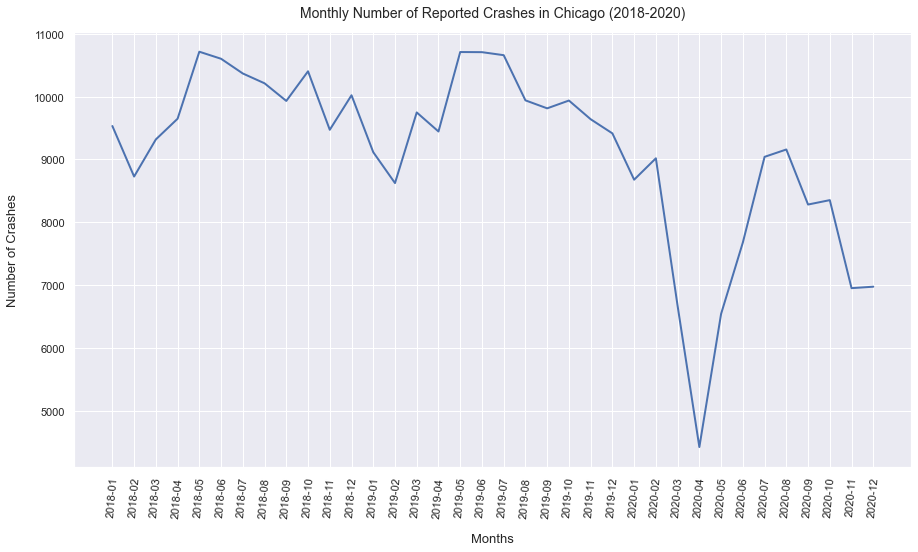

In [10]:
# Plot monthly number of reported crashes.
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df.groupby(df['CRASH_DATE'].dt.strftime('%Y-%m'))['CRASH_RECORD_ID'].nunique(), color='b', linewidth=2)
s.set_title('Monthly Number of Reported Crashes in Chicago (2018-2020)', y=1.02, fontsize=14)
s.set_xlabel('Months', fontsize=13, labelpad=15)
s.set_ylabel('Number of Crashes', fontsize=13, labelpad=15)

for item in s.get_xticklabels():
    item.set_rotation(85)

**Observation:** The onset of the coronavirus pandemic had a dramatic impact on the number of reported crashes in Chicago in the first half of 2020.  Reported crashes in the second half of 2020 remain lower than historical norms.

**Observation:** In prior years, the number of reported crashes generally dips in Janaury or February, and peaks in May and June. 

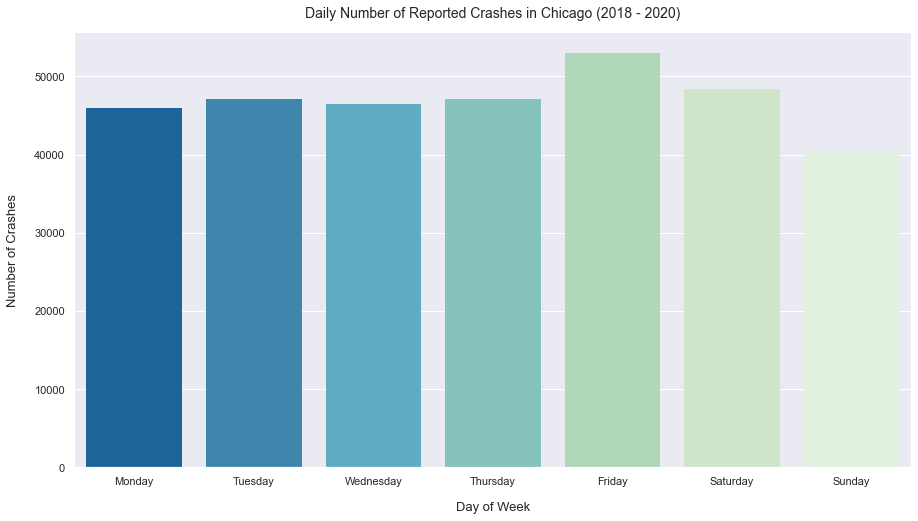

In [11]:
# Add column containing day of week that crash occured.
df['Day'] = df['CRASH_DATE'].dt.dayofweek

# Plot number of crashes by day of week.
plt.figure(figsize=(15,8))
s = sns.barplot(data=df.groupby('Day')['CRASH_RECORD_ID'].nunique().reset_index(), x='Day', y='CRASH_RECORD_ID', palette='GnBu_r', linewidth=0)
s.set_title('Daily Number of Reported Crashes in Chicago (2018 - 2020)', y=1.02, fontsize=14)
s.set_xlabel('Day of Week', fontsize=13, labelpad=15)
s.set_ylabel('Number of Crashes', fontsize=13, labelpad=15)
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

**Observation:** The number of reported crashes in Chicago is remarkably stable across the days of the week, with a slightly higher total on Friday and slightly lower total on Sunday.

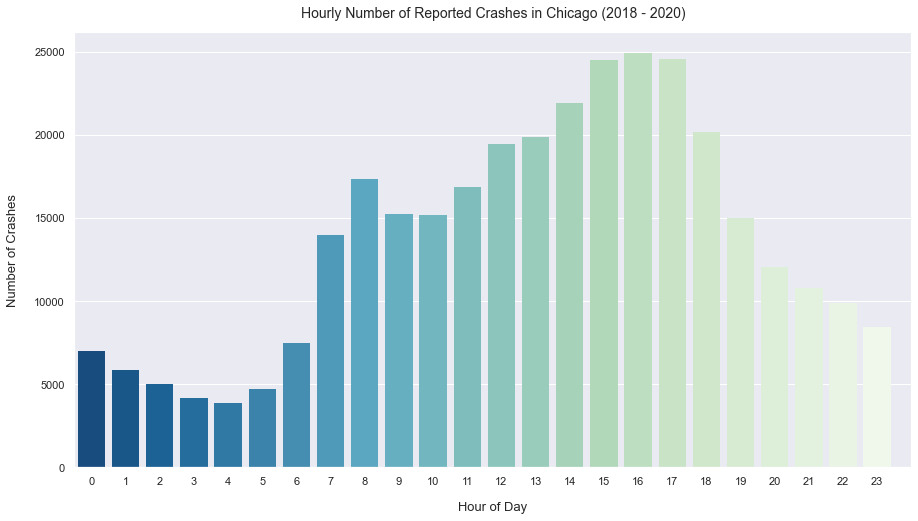

In [12]:
# Add column containing hour of day that crash occured.
df['Hour'] = df['CRASH_DATE'].dt.hour

# Plot number of crashes by hour of day.
plt.figure(figsize=(15,8))
s = sns.barplot(data=df.groupby('Hour')['CRASH_RECORD_ID'].nunique().reset_index(), x='Hour', y='CRASH_RECORD_ID', palette='GnBu_r', linewidth=0)
s.set_title('Hourly Number of Reported Crashes in Chicago (2018 - 2020)', y=1.02, fontsize=14)
s.set_xlabel('Hour of Day', fontsize=13, labelpad=15)
s.set_ylabel('Number of Crashes', fontsize=13, labelpad=15)
plt.xticks(np.arange(0,25))
plt.show()

**Observation:** Reported crashes in Chicago most often occur during standard commuting times in the morning and afternoon / early evening.

**Observation:** The number of reported crashes in the early hours of the morning did come as a bit of a surprise.

### 4. Explore Types of Crashes

In [13]:
# Group by crash type and count the number of crashes in each group.
df_types = df.groupby([df['CRASH_DATE'].dt.strftime('%Y-%m'), 'FIRST_CRASH_TYPE'])['CRASH_RECORD_ID'].nunique().reset_index(name='COUNT')

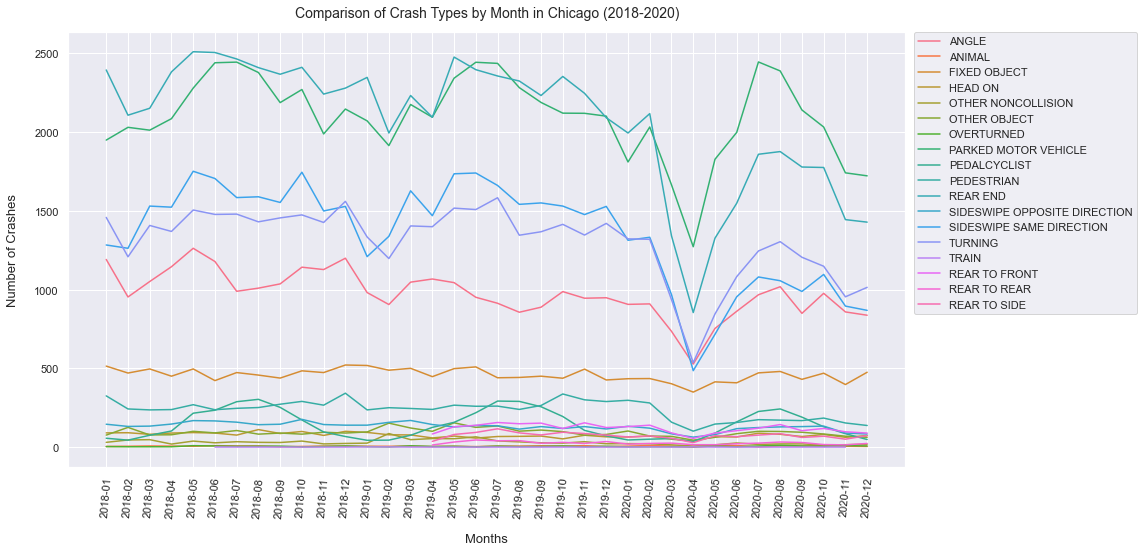

In [14]:
# Display a plot comparing the number of crashes per month by type.
plt.figure(figsize=(15,8))
s = sns.lineplot(data=df_types, x='CRASH_DATE', y='COUNT', hue='FIRST_CRASH_TYPE')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
s.set_title('Comparison of Crash Types by Month in Chicago (2018-2020)', y=1.02, fontsize=14)
s.set_xlabel('Months', fontsize=13, labelpad=15)
s.set_ylabel('Number of Crashes', fontsize=13, labelpad=15)

for item in s.get_xticklabels():
    item.set_rotation(85)
    
plt.show()

**Observation:** As we saw above, the number of reported crashes in Chicago decreased significantly in the first half of 2020.  Generally, the number of each type of crash remains relatively stable over time.

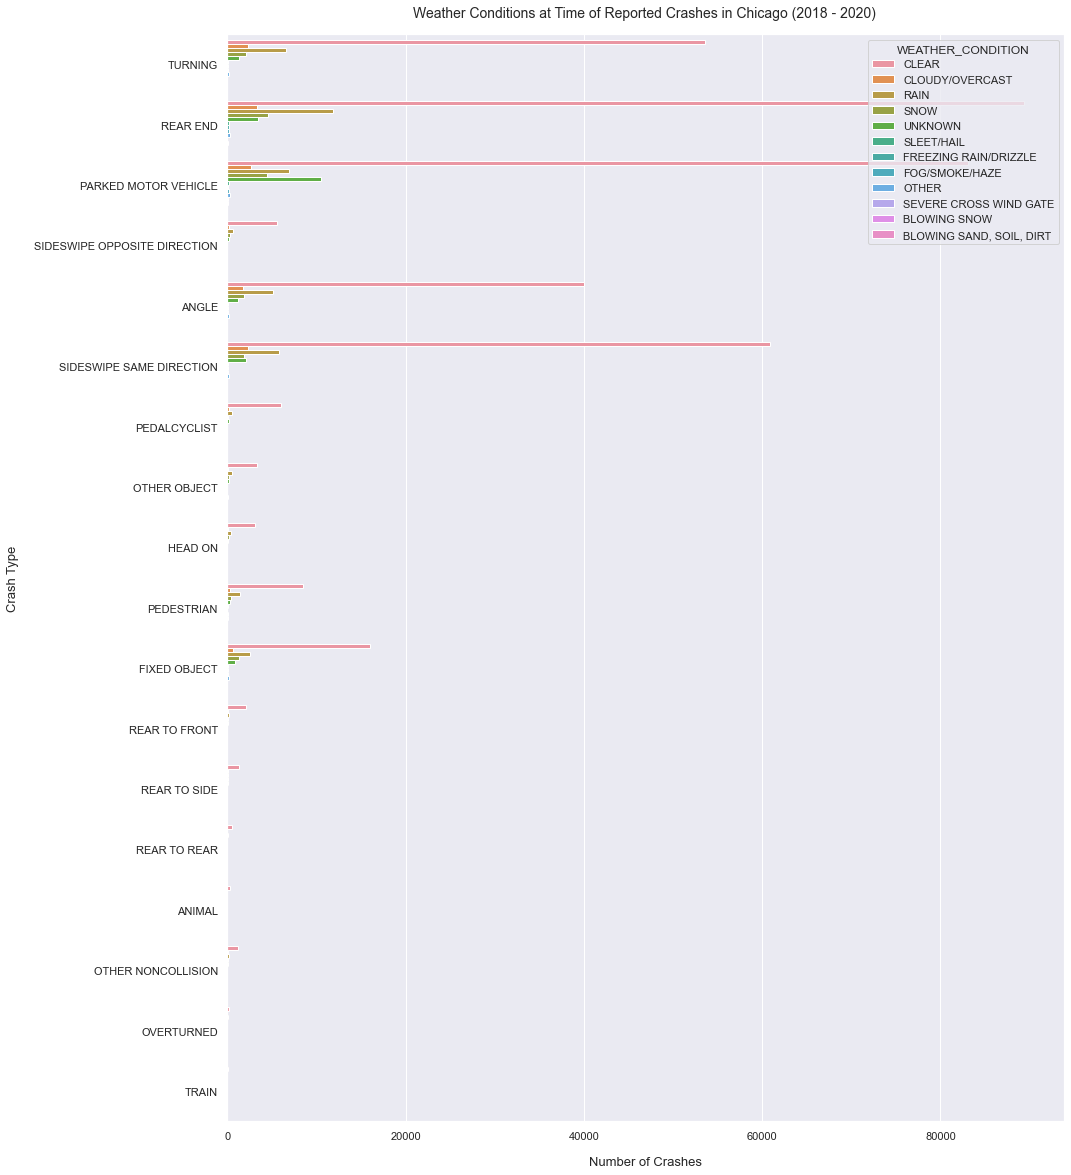

In [15]:
# Display a plot showing the weather conditions at the time of reported crashes, splitting out by type of crash.
plt.figure(figsize=(15, 20))
sns.countplot(data=df_crashes, hue='WEATHER_CONDITION', y='FIRST_CRASH_TYPE')
plt.title('Weather Conditions at Time of Reported Crashes in Chicago (2018 - 2020) ', y=1.01, fontsize=14)
plt.xlabel('Number of Crashes', fontsize=13, labelpad=15)
plt.ylabel('Crash Type', fontsize=13, labelpad=15)
plt.show();

**Observation:** It is evident from the above plot that a vast majority of crashes, no matter what the type of crash, occur in clear weather conditions.

### 5. Explore Primary Contributing Cause of Reported Crashes

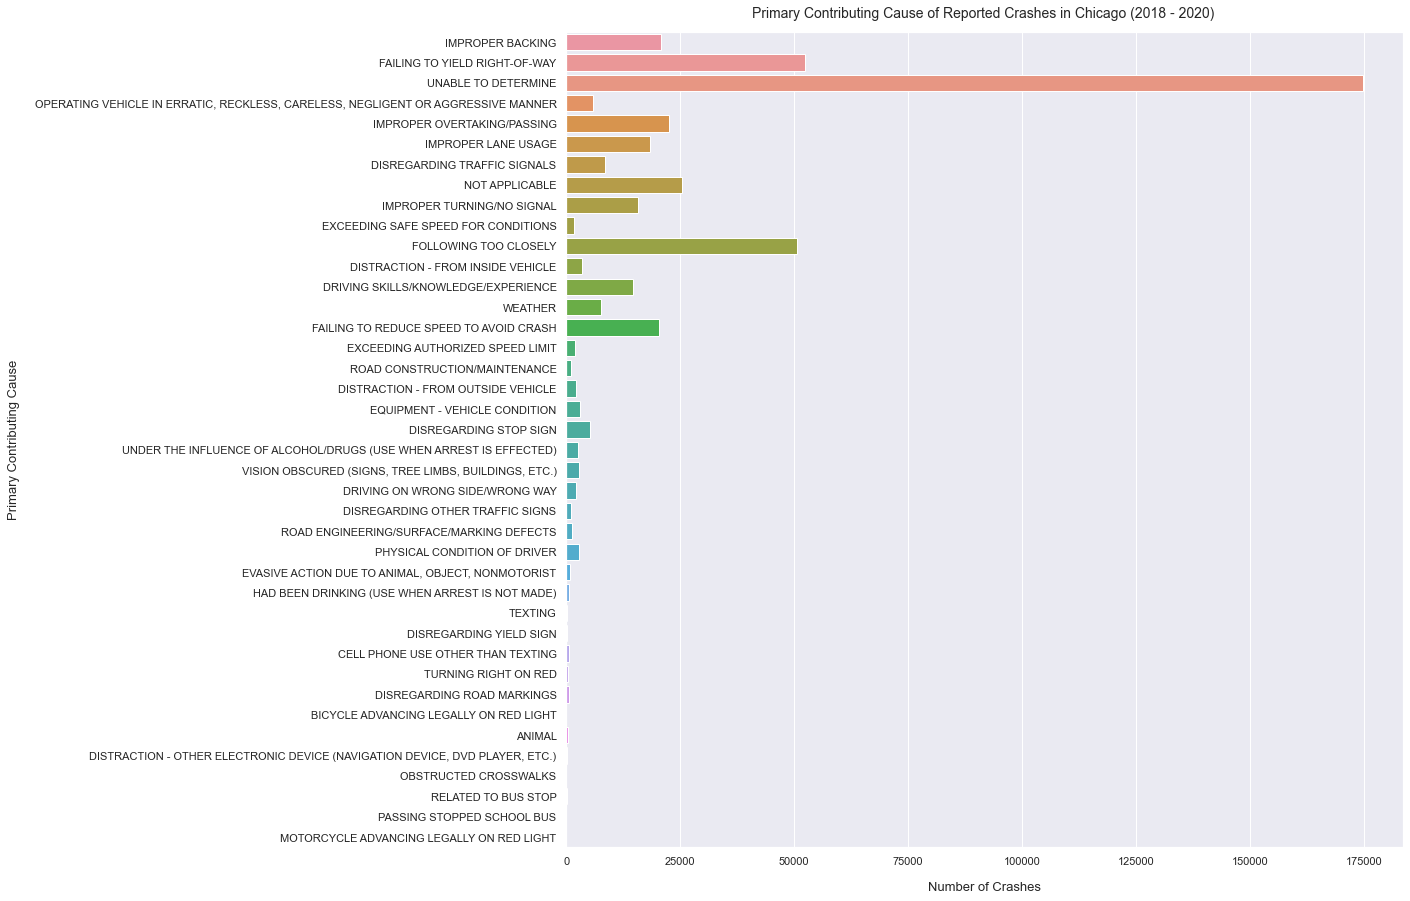

In [16]:
# Display a plot showing the primary contributing cause of reported crashes.
plt.figure(figsize=(15, 15))
sns.countplot(data=df_crashes,  y='PRIM_CONTRIBUTORY_CAUSE')
plt.title('Primary Contributing Cause of Reported Crashes in Chicago (2018 - 2020) ', y=1.01, fontsize=14)
plt.xlabel('Number of Crashes', fontsize=13, labelpad=15)
plt.ylabel('Primary Contributing Cause', fontsize=13, labelpad=15)
plt.show();

**Observation:** A large proportion of reported crashes in Chicago have an undetermined cause.  This is worringly high and may indicate a lack of training of crash responders / investigators, or laziness on their part to investigate and correctly record the cause.  For any effort to decrease crashes to be successful, the actual causes of the crashes need to be determined and then mitigated through laws, roading improvements and enforcement measures.

In [17]:
# Determine the proprtion of fatalities resulting from reported crashes where the primary contributory cause was not determined.
df_crashes[df_crashes['PRIM_CONTRIBUTORY_CAUSE'] == 'UNABLE TO DETERMINE']['INJURIES_FATAL'].sum() / df_crashes['INJURIES_FATAL'].sum()

0.3076923076923077

### 6. Explore Locations of Reported Crashes

In [18]:
# Drop records without location coordinates and subset to crashes with fatalities.
df_fatal = df_crashes[df_crashes['LONGITUDE'].notna()]
df_fatal = df_fatal[df_fatal['INJURIES_FATAL'] > 0]

In [19]:
# Display a map of crash fatalities.

# Create a map centered on Chicago.
m = folium.Map(location=[41.8781, -87.6798], zoom_start=12)

# Instantiate a mark cluster object for the crash fatalities.
fatalities = plugins.MarkerCluster().add_to(m)

# Display only crashes where fatalities were reported.
for lat, lng in zip(df_fatal['LATITUDE'], df_fatal['LONGITUDE']):
    folium.Marker(
        location=[lat, lng],
           icon=None,
    ).add_to(fatalities)

# Display the map.
m

In [20]:
# Subset to crashes with alcohol as the primary contributing cause and drop records without location coordinates.
df_alcohol = df_crashes[df_crashes['PRIM_CONTRIBUTORY_CAUSE'].str.contains('ALCOHOL|DRINKING')]
df_alcohol = df_alcohol[df_alcohol['LONGITUDE'].notna()]

In [21]:
# Display a map of reported crashes with alcohol as the primary cause.

# Create a map centered on Chicago.
m = folium.Map(location=[41.8781, -87.6798], zoom_start=12)

# Nested list that contains the latitude and the longitude of the alcohol related crashes. 
hour_list = [[] for _ in range(24)]
for lat,log,hour in zip(df_alcohol['LATITUDE'], df_alcohol['LONGITUDE'], df_alcohol['CRASH_DATE'].dt.hour):
    hour_list[hour].append([lat,log]) 

# Labels indicating the hours.
index = [str(i)+' Hours' for i in range(24)]

# Instantiate a heat map with time object for the alcohol related crashes.
HeatMapWithTime(hour_list, index).add_to(m)

# Display the map.
m

### 7. Forecast the Number of Crashes in 2021 and 2022 Using Prophet.

In [22]:
# Group by month and count the number of crashes per month.
df_forecast = df_forecast.groupby(df_forecast['CRASH_DATE'].dt.strftime('%Y-%m'))['CRASH_RECORD_ID'].nunique().reset_index(name='COUNT')

In [23]:
# Prophet requires columns to have specific names: ds (date) and y (value).
df_forecast = df_forecast.rename(columns={'CRASH_DATE': 'ds', 'COUNT': 'y'})

# Because of the coronavirus pandemic in 2020, I will zero out the values for the months of 2020, otherwise they will incorrectly influence the forecast.
# In Prophet the best way to handle outliers is to remove them - Prophet has no problem with missing data and will give a prediction for their values.
df_forecast.loc[(df_forecast['ds'] >= '2020-01-01') & (df_forecast['ds'] <= '2020-12-31'), 'y'] = None

In [24]:
prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
prophet.fit(df_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


In [25]:
# Make a future dataframe for 2 years, which is 24 months.
df_forecast = prophet.make_future_dataframe(periods=24, freq='M')

# Create the forecast.
df_forecast = prophet.predict(df_forecast)

<Figure size 1080x576 with 0 Axes>

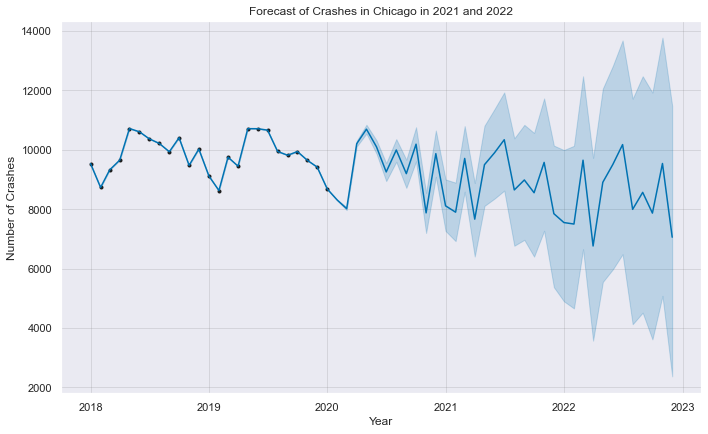

In [26]:
# Plot the forecast.
plt.figure(figsize=(15,8))
prophet.plot(df_forecast, xlabel = 'Year', ylabel = 'Number of Crashes')
plt.title('Forecast of Crashes in Chicago in 2021 and 2022');